In [377]:
# Importing all required methods
%matplotlib inline

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import os
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import myutils
from sklearn.model_selection import train_test_split
import librosa
from pathlib import Path
import cv2 as cv

In [9]:
# Directory where mp3 are stored.
AUDIO_DIR = os.environ.get('AUDIO_DIR')
# current_directory = os.getcwd()

# Load metadata and features.
tracks = myutils.load('data/fma_metadata/tracks.csv')
genres = myutils.load('data/fma_metadata/genres.csv')
features = myutils.load('data/fma_metadata/features.csv')
echonest = myutils.load('data/fma_metadata/echonest.csv')

In [28]:
# get tracks for small data set
d_size = 'small'
selected_tracks = tracks[tracks['set', 'subset'] <= d_size]

# select top genre column
hottest_genres = selected_tracks["track"]["genre_top"]
hottest_genres = hottest_genres.to_frame()
hottest_genres = hottest_genres.dropna()

# get indices
ids = hottest_genres.index.values.reshape(-1, 1)
# note: track ids for tracks that ONLY have a valid top_genre

# Extract categories from categorical column
categories = hottest_genres['genre_top'].cat.categories

# Convert categories to a dictionary mapping category values to integer indices
categories_dict = {category: i for i, category in enumerate(categories)}

# convert to integer codes
hottest_genres['genre_top'] = hottest_genres['genre_top'].cat.codes

# convert to array
hottest_genres = np.array(hottest_genres)

# create labels data 
labels = np.zeros((hottest_genres.shape[0], 16))
labels[np.arange(hottest_genres.shape[0]), hottest_genres.flatten()] = 1

In [29]:
# filter the feature dataframe to only have the tracks in 'ids':

# flattening ids to single list, to make easier to work with
flattened_ids = [item for sublist in ids for item in sublist]

# filtering the ids out from features
selected_features = features.loc[flattened_ids]
features_data = np.array(selected_features)

(8000, 518)


In [296]:
# dimensionality reduction for features, dimensionality reduction over the features
num_components = int(features.shape[1]/2)

# pca dimensionality reduction, might try an autoencoder later
pca = PCA(n_components=num_components)
pca.fit(features_data)
f_data = pca.transform(features_data)

In [298]:
# create pytorch dataset
dataset = TensorDataset(torch.tensor(f_data).float(), torch.tensor(labels))

# reproducibility
torch.manual_seed(69)

# train, test, validation split
train_size = int(0.8 * len(dataset))  # 80% 
val_size = int(0.1 * len(dataset))    # 10% 
test_size = len(dataset) - train_size - val_size  # 10%

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=80, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=80)
test_loader = DataLoader(test_dataset, batch_size=80)


In [304]:
# define accuracy function
def get_accuracy(model, data):
    loader = torch.utils.data.DataLoader(data, batch_size=256)
    model.eval() # annotate model for evaluation (important for batch normalization)
    correct = 0
    total = 0
    for x, t in loader:
        output = model(x)
        labels = torch.argmax(t, dim=1)
        pred = torch.argmax(output, dim=1)
        correct += (pred == labels).sum()
        total += x.shape[0]
    return correct / total

# define model architecture,
class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(num_components, 220)  # Input size: 12, Output size: 64
        self.fc2 = nn.Linear(220, 80)  # Input size: 64, Output size: 32
        self.fc3 = nn.Linear(80, 40)  # Input size: 32, Output size: 16
        self.fc4 = nn.Linear(40, 16)  # Input size: 16, Output size: 16 (for the number of classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.softmax(self.fc4(x), dim=1)  # Apply softmax to get class probabilities
        return x


In [324]:
# hyperaramters
lr = 0.0006

# instantiate model 
fnn_model = FNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(fnn_model.parameters(), lr=lr)

Iter 1000; Loss 2.432430; Train Acc 0.430; Val Acc 0.391
Iter 2000; Loss 2.363083; Train Acc 0.510; Val Acc 0.420
Iter 3000; Loss 2.357369; Train Acc 0.547; Val Acc 0.411
Iter 4000; Loss 2.256075; Train Acc 0.615; Val Acc 0.465
Iter 5000; Loss 2.191265; Train Acc 0.662; Val Acc 0.500
Iter 6000; Loss 2.140975; Train Acc 0.701; Val Acc 0.534
Iter 7000; Loss 2.103296; Train Acc 0.774; Val Acc 0.543
Iter 8000; Loss 2.160766; Train Acc 0.784; Val Acc 0.536
Iter 9000; Loss 2.054909; Train Acc 0.788; Val Acc 0.544
Iter 10000; Loss 1.977422; Train Acc 0.808; Val Acc 0.551
Iter 11000; Loss 2.093429; Train Acc 0.782; Val Acc 0.534
Iter 12000; Loss 2.050562; Train Acc 0.809; Val Acc 0.540
Iter 13000; Loss 2.092691; Train Acc 0.812; Val Acc 0.551
Iter 14000; Loss 2.011241; Train Acc 0.817; Val Acc 0.550
Iter 15000; Loss 2.025001; Train Acc 0.824; Val Acc 0.560
Iter 16000; Loss 2.075865; Train Acc 0.835; Val Acc 0.554
Iter 17000; Loss 2.049415; Train Acc 0.826; Val Acc 0.554
Iter 18000; Loss 2.0483

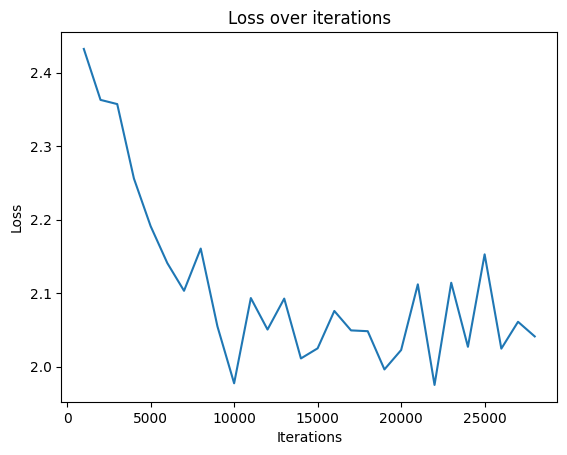

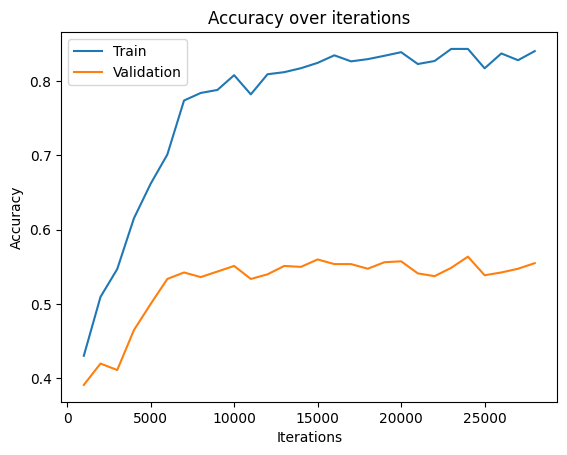

In [325]:
# train the model
def train_model(model, criterion, optimizer, num_epochs):
    # for plotting
    iters, train_loss, train_acc, val_acc = [], [], [], []
    iter_count = 0 # count the number of iterations that has passed
    plot_every = 1000

    # Training loop
    for epoch in range(num_epochs):
        model.train() # train model
        for inputs, targets in train_loader:
            optimizer.zero_grad() # avoid gradient accumulaiton per batch
            outputs = model(inputs) # get outputs
            loss = criterion(outputs, targets.argmax(dim=1)) # compute loss
            loss.backward() # backpropagation
            optimizer.step() # update parameters

            iter_count += 1
            if iter_count % plot_every == 0:
                loss = float(loss)
                tacc = get_accuracy(model, train_dataset)
                vacc = get_accuracy(model, val_dataset)
                print("Iter %d; Loss %f; Train Acc %.3f; Val Acc %.3f" % (iter_count, loss, tacc, vacc))

                iters.append(iter_count)
                train_loss.append(loss)
                train_acc.append(tacc)
                val_acc.append(vacc)
                
    plt.figure()
    plt.plot(iters[:len(train_loss)], train_loss)
    plt.title("Loss over iterations")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    plt.figure()
    plt.plot(iters[:len(train_acc)], train_acc)
    plt.plot(iters[:len(val_acc)], val_acc)
    plt.title("Accuracy over iterations")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(["Train", "Validation"])
train_model(fnn_model, criterion, optimizer, 350)

In [326]:
# test accuracy
tacc = get_accuracy(fnn_model, test_dataset)
print("the test accuracy of the model is {}".format(tacc))

the test accuracy of the model is 0.5837500095367432


In [388]:
# audio to spectrogram converter
def spectrogrammer(mp3_path, alpha):

    # Load the audio file
    y, sr = librosa.load(mp3_path, sr=22050)

    # pre-emphasis filter to improve noise to signal ratio
    y = librosa.effects.preemphasis(y, coef=alpha)

    # Compute the spectrogram
    D = librosa.stft(y)

    D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

    D_db = cv.resize(D_db, dsize=(450, 450), interpolation=cv.INTER_CUBIC)

    return D_db




In [ ]:
# build spectrogram data
alpha = 0.97

image_data = []
def build_a_bear(directory_path):
    directory = Path(directory_path)  # Use Path object for directory
    for folder in sorted(directory.iterdir()):  # Iterate through folders in sorted order (id order)
        if folder.is_dir():
            for file_path in sorted(folder.iterdir()):  # Iterate through files in sorted order (id order)
                spec_array = spectrogrammer(file_path, alpha)
                image_data.append(spec_array)

directory_path = 'data/fma_small'
build_a_bear(directory_path)

image_data = np.array(image_data)

(62, 450, 450)


In [ ]:
# TODO: Create 8000xspectrogram_data for each track